In [2]:
from __future__ import print_function, division
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import csv

# Objective Function Definition

In [3]:
def objective_lr_1(Y,I,J,x_cus,x_icp,y_cus,y_icp):
    """Calculate The cost distances Custoner/ICP
    
        Parameters:
        I,J sets of customers and ICP
        x_cus,y_cus geographique position of customers
        x_icp,y_icp geographique position of ICPs
        
        Decision variable:
        Y_ij if customer i associated with ICP j
    """
    s = 0
    for i in range(I):
        for j in range(J):
            s += sqrt((x_cus[i] - x_icp[i])**2 +  (y_cus[i]  - y_icp[i])**2) * Y[i][j]
            
    return s

In [4]:
def objective_lr_2(N,J,FCT):
    """Setup cost for ICPs
    
        Parameters:
        J sets of ICP
        FTC_j setup cost for ICP j

        Decision variable:
        N_j ICP j is open
    """
    s = 0
    for j in range(J):
        s += FTC[j]*N[j]
            
    return s

In [5]:
def objective_lr_3(I,K,V,q,IP):
    """Product acquisition cost
    
        Parameters:
        I,K,V sets of customers, quality level, and product varieties
        q_iv unit of return product custoner i quality v
        IP incentive cost for acquisition

        Decision variable:

    """
    s = 0
    for i in range(I):
        for k in range(K):
            for v in range(V):
                s += q[i][v] * IP[i][k][v]
            
    return s

In [6]:
def objective_lr_4(Z,C,J,B,D_crc_icp,D_crc_pc):
    """Routing ICP->CRC->PC
    
        Parameters:
        C,J,B sets of customers, quality level, and product varieties
        D_crc_icp distance between CRC_c and ICP_j
        D_crc_pc  distance between CRC_c and PC

        Decision variable:
        Z_cjb vehicle travel from CRC_c to ICP_j on route b
    """
    s = 0
    for c in range(C):
        for j in range(J):
            for b in range(B):
                s += (D_crc_icp[c][j] + D_crc_pc[c])* Z[c][j][b]
            
    return s

In [7]:
def objective_lr_5(N,S,FCR):
    """Product acquisition cost
    
        Parameters:
        S set of CRC
        FCR setup cost of CRC_c

        Decision variable:

    """
    s = 0
    for c in range(S):
        s += FCR[c]*N
            
    return s

In [8]:
def objective_lr_6(I,K,V,q,PC):
    """Processing cost
    
        Parameters:
        I,K,V sets of customers, quality level, and product varieties
        q_iv unit of return product custoner i quality v
        PC procesing cost

        Decision variable:

    """
    s = 0
    for i in range(I):
        for k in range(K):
            for v in range(V):
                s += q[i][v] * PC[i][k][v]
            
    return s

In [9]:
def objective_lr_7(Z,C,J,B,FCV):
    """Routing ICP->CRC->PC
    
        Parameters:
        C,J,B sets of customers, quality level, and product varieties
        FCV_b fixed cost associated to vehivle b

        Decision variable:
        Z_cjb vehicle travel from CRC_c to ICP_j on route b

    """
    s = 0
    for b in range(B):
        s_sub = 0
        for c in range(C):
            for j in range(J):
                s_sub += Z[c][j][b]
        s += FCV[b] * sum_7_sub
            
    return s

In [10]:
def objective_lr(decisionVariables, p):
    """
    Parameters:
        Sets:
            I,J,C,K,V,B -> customer, ICPs, CRCs, qualities, varieties, vehicles
        Costs:
            FCT, FCR, FCV
            IP, PC
         Weight:
            q,
            D_crc_icp, D_crc_pc
     
     Decision Vqriables:
        Y_ij customer i associated to ICP j
        Z_cjb vehicle travel from CRC_c to ICP_j on route b
        N_icp, N_crc -> ICP / CRC i is open
    """
    
    ############################################
    ## Extraction
    I = p.sets.I
    J = p.sets.J
    C = p.sets.C
    K = p.sets.K
    V = p.sets.V
    B = p.sets.B
    
    ############################################
    ## Variable cost
    
    # 1. Distance betwwen customer and facilies
    objective_lr_1(Y,I,J,x_cus,x_icp,y_cus,y_icp)
    # 4. Routing ICP->CRC->PC
    objective_lr_4(Z,C,J,B,D_crc_icp,D_crc_pc)
    
    ############################################
    ## Fixed costs
    
    # 2. Cost of establishing ICPs
    objective_lr_2(N_icp,J,FCT)
    # 5. Fixe cost for establishing CRCs
    objective_lr_5(N_crc,S,FCR)
    # 7. Fixe cost for vehicles
    objective_lr_7(Z,C,J,B,FCV)
    ############################################
    ## Acquisition an processing cost
    
    # 3. Acquisition cost
    objective_lr_3(I,K,V,q,IP)
    # 6. Processing cost
    objective_lr_6(I,K,V,q,PC)

# Objective function Tests

# Objective function Transformation

We devide the objective function into three par:
* Facility location problem
* Routing problem
* Acquisition, processing

## Location routing problem

$min_{Y,N_icps,N_crcs}$ 
$$ \sum_{j \in J} FTC_j * Nicp_j + \sum_{c \in C} FTR_c * Ncrc_c +  \sum_{i \in I}\sum_{j \in J} W_{ij}*Y_{ij} $$

$s.t:$
$$ \sum_{j \in J} Y_{ij} = 1, \forall i \in I $$
$$ \sum_{j \in J} Y_{ij} = 1, \forall i \in I $$

### Definition

In [11]:
def objective_lr_flp(Y,N_icp,N_crc,
                     I,J,C,
                     W,FCT,FCR):
    """Calculate cost associated to facility location
    
        equivalent: 1,2,5
    
        Parameters:
        I,J,C sets of customers, ICP, and CRC
        W euclidienne distance between customer and ICP
        FTC, FCR setup cost for ICP qnd CRC
        
        Decision variable:
        Y_ij if customer i associated with ICP j
        N_crc CRC c is open
        N_icp is open
    """  
    s1 = 0
    s2 = 0
    s5 = 0
    
    # 1
    for i in range(I):
        for j in range(J):
            s1 += W[i][j] * Y[i][j]
    # 2      
    for j in range(J):
        s2 += FCT[j][0]*N_icp[j]
    # 5    
    for c in range(C):
        s5 += FCR[c][0]*N_crc[c]
        
    return s1+s2+s5,s1,s2,s5

### Visualization

In [12]:
xy_customers = list(csv.reader(
    open('./datasets/original/xy_customers.csv'),delimiter=';',
    quoting=csv.QUOTE_NONNUMERIC))

xy_icps = list(csv.reader(
    open('./datasets/original/xy_icps.csv'),delimiter=';',
    quoting=csv.QUOTE_NONNUMERIC))

xy_crcs = list(csv.reader(
    open('./datasets/original/xy_crcs.csv'),delimiter=';',
    quoting=csv.QUOTE_NONNUMERIC))

In [19]:
%%file "./pkg/lrp_nodes_graph.py"

import networkx as nx

def lrp_nodes_graph(xy_customers, xy_icps, xy_crcs):
    G = nx.Graph()
    colors=[]
    pos=[]
    labels={}
    
    num_cus = len(xy_customers)
    num_icps = len(xy_icps)

    for i, val in enumerate(xy_customers):
        G.add_node(i)
        pos.append((val[0],val[1]))
        colors.append("blue")
        labels[i]=""

    for i, val in enumerate(xy_icps):
        G.add_node(i+num_cus)
        pos.append((val[0],val[1]))
        colors.append("red")
        labels[i+num_cus]="icp"+str(i)

    for i, val in enumerate(xy_crcs):
        G.add_node(i+num_cus+num_icps)
        pos.append((val[0],val[1]))
        colors.append("green")
        labels[i+num_cus+num_icps]="crc"+str(i)
        
    return G, pos, labels, colors

Writing ./pkg/lrp_nodes_graph.py


In [20]:
from pkg.lrp_nodes_graph import lrp_nodes_graph
G, pos, labels, colors = lrp_nodes_graph(xy_customers, xy_icps, xy_crcs)

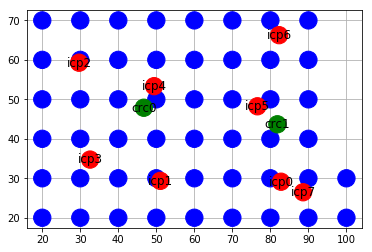

In [14]:
plt.grid('on')
nx.draw_networkx(G,pos,labels=labels,node_color=colors,with_labels=True)
plt.show()

### Tests

In [15]:
## I,J,C, ##
I = 50
J = 8
C = 2
## Y ##
adj_list_icp_cus = [ 
    [31,32,45,49],
    [13,19,20,21,25,26],
    [4,5,6,10,11,12,17,18],
    [1,2,3,7,8,9,14,15],
    [16,22,23,24,27,28,29,30],
    [33,34,35,39,40,46],
    [36,41,42,47,48],
    [37,38,43,44,50]
]

Y = np.zeros((I,J))

for j,val in enumerate(adj_list_icp_cus):
    for i in val:
        Y[i-1][j] = 1
        
## N ##
N_icp = np.ones(J)
N_crc = np.ones(C)
## W,FTC,FCR ##
W = list(csv.reader(
    open('./datasets/original/W.csv'),delimiter=';',
    quoting=csv.QUOTE_NONNUMERIC))

FCT = list(csv.reader(
    open('./datasets/original/FCT.csv'),delimiter=';',
    quoting=csv.QUOTE_NONNUMERIC))

FCR = list(csv.reader(
    open('./datasets/original/FCR.csv'),delimiter=';',
    quoting=csv.QUOTE_NONNUMERIC))

In [16]:
objective_lr_flp(Y,N_icp,N_crc,
                     I,J,C,
                     W,FCT,FCR)

(1732.0012543090002, 532.00125430900005, 800.0, 400.0)

In [17]:
for j,val in enumerate(adj_list_icp_cus):
    for i in val:
        G.add_edge(I+j,i-1)

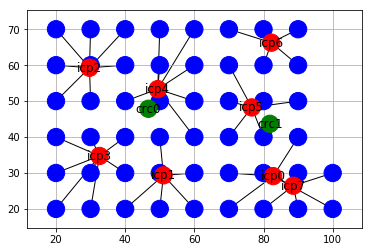

In [18]:
plt.grid('on')
nx.draw_networkx(G,pos,labels=labels,node_color=colors,with_labels=True)
plt.show()